In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_rain_alphas, weather_costs, model_01, validate, prediction

production of summation of dengue with season and weather
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

In [36]:
all_weather = pd.read_csv("weather01-16.csv")

In [37]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

In [38]:
cm_avg_weather = cm_weather[['avgrh','dday','meantemp']].resample('W').mean()
cm_avg_weather['rain'] = cm_weather[['rain']].resample('W').sum() # cumulative rainfall
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [39]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction with Mean Temperature"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def show_predictions(params, real, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS = params[0], params[1], params[2]
    
    predictions_to_plot = prediction.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real.cases,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)
    
    

In [42]:
import multiprocessing as mp
from multiprocessing import Process, Queue

# Define an output queue
output = Queue()

# def validate

# def compute_ret(temp):
#     for i in range(int(1e5)): pass
#     return temp/2.


ws_csv = np.array(pd.read_csv("best-with-19-lags-10-temps-14-rains-ws-1st-iter-model-a.csv").T)[0]
    
def validation(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, train, real, output):
                                    # get_alphas takes 4 args, if theres no input csv
    alphas = weather_rain_alphas.get_alphas(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, train, ws_csv)
                                    # get_predictions takes 6 args
    predictions_to_validate = prediction.get_predictions(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, real, alphas.x, "CM")
                                    # get_validations takes 3 argsg
    validated_result = validate.get_validations(LAG, predictions_to_validate, real)
    output.put((RAIN_WEEKS,validated_result,alphas.x)) # add in ws as well alphas.x


In [ ]:
%%time
# Setup a list of processes that we want to run
train = cm_dengues_train
real = cm_dengues_weather
processes = [Process(target=validation, args=(19, 10, weeks, train, real, output)) for weeks in range(7,16)]
print ws_csv

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

[  3.59358229e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.20838374e-11   0.00000000e+00   3.32451640e-08   4.11540030e-03
   2.05223867e-08   4.64082251e-08   4.99123959e-08   6.75703941e-08
   6.69284430e-02   1.21055304e-01   2.80146008e-03   3.74153042e-05
   5.04107189e-12   4.48131078e-06   9.59487824e-08   4.85013861e-01
   1.80254006e+00   7.81415076e+00   2.01010260e-01   4.93972027e-02
  -4.85137240e-03  -3.63145458e-02  -2.33041083e-02  -1.47755908e-02
  -1.27827342e-02   3.67567358e-04   3.18596151e-03  -9.89913882e-03
   1.74654269e-02   5.55155314e-02  -1.66857936e-03   1.72733455e-03
  -2.60922716e-03  -2.37791010e-03   9.75554312e-04   3.70119206e-04
  -7.62103601e-04   4.75623226e-04   5.21528672e-04   3.62228938e-05
  -6.43214140e-04   1.99666965e-03  -1.43441222e-04  -9.65433207e-04]
41
LAG 19
bnds 19 41
ws_csv
prev_ws 33
all_prev_ws 41
42
LAG 19
prev_ws 33
bnds 19 42
43
ws_csv
LAG 19
prev_ws 33
bnds 19 43
ws_csv
all_prev_ws 42
all_prev_ws 43
44
LAG 19

In [16]:
def get_best(validations):
    idx = None
    best_so_far = validations[0][1][-1]
    print best_so_far
    for i in range(len(validations)):
        cur_validation = validations[i][1]
#         print cur_validation
        if cur_validation[0] <= best_so_far:
            best_so_far = cur_validation[0]
            idx = i
    return validations[idx]
        
    
best_param = get_best(results)

38708.9045301


In [17]:
best_param

(14,
 [226.48064300116104,
  508.99084871440516,
  1444.9705497504765,
  4239.3786450629341,
  9513.9610286165425],
 array([  3.59358229e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.20838374e-11,   0.00000000e+00,
          3.32451640e-08,   4.11540030e-03,   2.05223867e-08,
          4.64082251e-08,   4.99123959e-08,   6.75703941e-08,
          6.69284430e-02,   1.21055304e-01,   2.80146008e-03,
          3.74153042e-05,   5.04107189e-12,   4.48131078e-06,
          9.59487824e-08,   4.85013861e-01,   1.80254006e+00,
          7.81415076e+00,   2.01010260e-01,   4.93972027e-02,
         -4.85137240e-03,  -3.63145458e-02,  -2.33041083e-02,
         -1.47755908e-02,  -1.27827342e-02,   3.67567358e-04,
          3.18596151e-03,  -9.89913882e-03,   1.74654269e-02,
          5.55155314e-02,  -1.66857936e-03,   1.72733455e-03,
         -2.60922716e-03,  -2.37791010e-03,   9.75554312e-04,
          3.70119206e-04,  -7.62103601e-04,   4.75623226e-04,
          5.2152

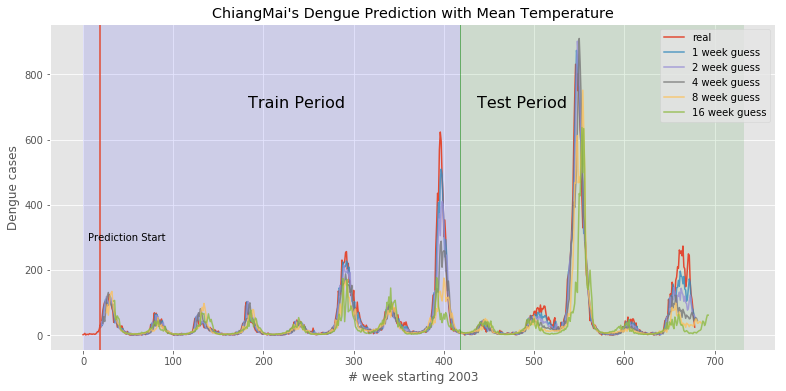

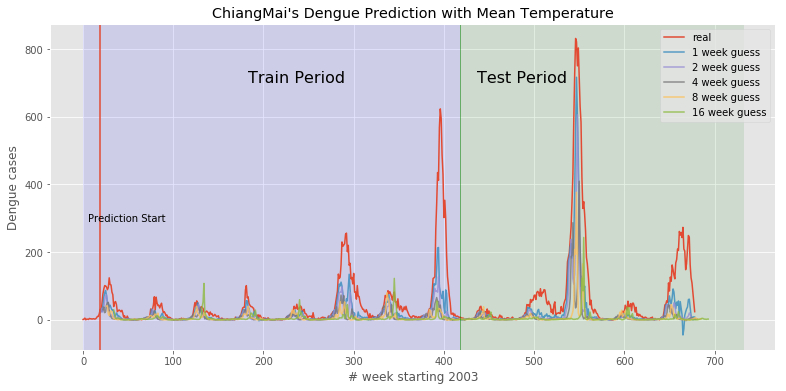

In [33]:
ws = np.array(pd.read_csv("best-with-19-lags-10-temps-ws-1st-iter.csv").T)[0]
ww = best_param[2]
real = cm_dengues_weather
show_predictions([19,10,14], real, "ChiangMai", ww)
show_predictions([19,10,10], real, "ChiangMai", ws)

In [27]:
# pd.DataFrame(best_param[2]).to_csv("best-with-19-lags-10-temps-14-rains-ws-1st-iter-model-a.csv",index=False)
# np.array(pd.read_csv("best-for-19-lags-ws-3rd-iter.csv").T)[0]

In [32]:
chosen_ws = glob.glob("best-*.csv")
for ws_set_file in chosen_ws:
    ws_set = np.array(pd.read_csv(ws_set_file).T)[0]
#     print ws_set_file
    LAG = int(ws_set_file[9:11])
    to_validate = prediction.get_predictions(LAG, 9, 10, real, ws_set)
    print "LAG %d"%LAG,validate.get_validations(LAG, to_validate, real)

LAG 23 [205.82624824351581, 374.86547851071168, 726.02637891644849, 1284.8735497820055, 1627.4597425170004]
LAG 21 [166.85156662968512, 292.0898130079363, 564.366573591867, 1035.0747400189584, 1527.0827702830245]
LAG 22 [168.91992707974032, 294.43310789395724, 581.26512237641293, 1094.9170235354613, 1583.9765963384611]
LAG 19 [166.58144315243547, 288.90438923758734, 543.77910579020795, 947.7903870066549, 1391.3705312824545]


In [147]:
# # pd.DataFrame(best_param[2]).to_csv("best-for-18-lags-ws.csv",index=False)

# lg = [16,17,18,20,22]
# a = np.array(pd.read_csv("best-for-18-lags-ws.csv").T)[0]

# # for i in lg:
# #     if i == len(a):
# #         arr = a
# #         print len(arr)
# #     elif i < len(a):
# #         arr = a[:-(18-i)]
# #         print len(arr)
# #     else:
# #         mean_val = 1/float(i)
# #         arr = np.append(a,[mean_val]*(i-len(a)))
# #         print arr
        
# def ws_helper(LAG, ws, 18):
#     n_ws = len(ws)
#     if LAG == n_ws:
#         print "eq"
#         arr = ws[:LAG+1]
#     elif LAG < n_ws:
#         print "les"
#         arr = ws[:-(n_ws - LAG + 1)]
#     else:
#         print "else"
#         tail = (LAG - n_ws) - 1
#         mean_val = 1/(float(LAG)*tail)
#         arr = np.append(ws,[mean_val]*tail)
#     return arr

# len(ws_helper(20,a))

les


19

In [69]:
%%time
[compute_ret(temp.get_alphas(i,9,10)) for i in range(16,26)]

NameError: name 'compute_ret' is not defined

In [10]:
print "im done"

im done


In [63]:
#extract temp given LAG
lg = 5
tmp = 2
a = [1,2,3,4,5,15,16,155]
def extract_temperature(LAG,TEMPERATURE_WEEKS, arr ):
    return arr[LAG:LAG+TEMPERATURE_WEEKS]
extract_temperature(5,2,a)

[15, 16]